### Real Options Valuation and Monte Carlo simulation, DM and FPOM.

**This is a sheet for working with all three cases investigated in Santeri's Master thesis on Real Options.**

Combining previously modeled calculations into a single Python-enabled Jupyter notebook. Generalizing, modularizing and improving outputs.

**Note:** To avoid errors ensure all notebook cells are executed sequentially. 

### Setup

Implemented using the Conda kernel. Python version 3.9.18

In [99]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt

# Declare initial application state
case_data = {
    1: {
        "yearly_cash_flows": {
            "low": np.array([]),
            "base": np.array([]),
            "high": np.array([])
        },
        "inputs": {
        }
    },
    2: {
        "yearly_cash_flows": {
            "low": np.array([]),
            "base": np.array([]),
            "high": np.array([])
        },
        "inputs": {
        }
    },
    3: {
        "yearly_cash_flows": {
            "low": np.array([]),
            "base": np.array([]),
            "high": np.array([])
        },
        "inputs": {
        }
    },
}


### Utilities

Implements the necessary utility functions to generalize and abstract across business cases.

In [100]:
# This function processes a string of pasted spreadsheet cells and returns a numpy array
def import_pasted_spreadsheet_cells(pasted_cells):
    data = pasted_cells.replace(",", ".")
    data_list = data.split()
    data_floats = [float(x) for x in data_list]
    return np.array(data_floats)

# This function helps form total discounted values for projects out of yearly cash flow values needed for the simulation
def calculate_discounted_values(values_dict, risk_rate, start_period, periods_in_operation):
    # If the passed in values are launch costs, then we spread the that and discount it only for the years before launch.
    return {k: sum(v / (1 + risk_rate) ** period for period in range(start_period + 1, start_period + 1 + periods_in_operation)) for k, v in values_dict.items()}

### Import case data

Supports simple copy-pasting for long spreadsheet rows. All three cases are imported below.

In [108]:
# Import data for Case 1: Paptic product R&D
case_data[1]["yearly_cash_flows"]["low"] = import_pasted_spreadsheet_cells("0,00	0,00	-7,34	0,83	0,74	0,66	0,59	0,53") # pessimistic scenario
case_data[1]["yearly_cash_flows"]["base"] = import_pasted_spreadsheet_cells("0,00	0,00	-6,05	1,27	1,13	1,01	0,90	0,81") # base case scenario
case_data[1]["yearly_cash_flows"]["high"] = import_pasted_spreadsheet_cells("0,00	0,00	-4,75	2,64	2,35	2,10	1,88	1,68") # optimistic scenario
case_data[1]["inputs"]["start_operating_after_periods"] = 3 # After this amount of years operation starts
case_data[1]["inputs"]["periods_in_operation"] = 5 # Years of operation when launched and operating
case_data[1]["inputs"]["operating_risk_rate"] = 0.12 # Risk, hurdle or discount rate for operating cash flows
case_data[1]["inputs"]["launch_cost_risk_rate"] = 0.05 # Risk, hurdle or discount rate for launch costs
case_data[1]["inputs"]["yearly_op_revenues_range"] = {"pess": 2.5, "base": 3, "opti": 5} # Range of yearly operating revenues -> pess: pessimistic, base: base case, opti: optimistic
case_data[1]["inputs"]["yearly_op_cost_range"] = {"pess": 1.2, "base": 1, "opti": 0.85} # Range of yearly operating costs -> pess: pessimistic, base: base case, opti: optimistic
case_data[1]["inputs"]["total_launch_cost_range"] = {"pess": 8.5, "base": 7, "opti": 5.5} # Range of total launch costs -> pess: pessimistic, base: base case, opti: optimistic

# Import data for Case 2: Callio energy storage system
case_data[2]["yearly_cash_flows"]["low"] = import_pasted_spreadsheet_cells("-19,42	-18,85	4,90	4,58	4,28	4,00	3,74	3,49	3,26	3,05	2,85	2,66	2,49	2,33	2,17	2,03	1,90	1,78	1,66	1,55	1,45	1,35	1,27	1,18	1,11	1,03	0,97	0,90	0,84	0,79	0,74	0,69	0,64	0,60	0,56	0,53	0,49	0,46	0,43	0,40	0,37	0,35	0,33	0,31	0,29	0,27	0,25	0,23	0,22	0,20	0,19	0,18") # pessimistic scenario
case_data[2]["yearly_cash_flows"]["base"] = import_pasted_spreadsheet_cells("-16,99	-16,50	6,82	6,38	5,96	5,57	5,21	4,87	4,55	4,25	3,97	3,71	3,47	3,24	3,03	2,83	2,65	2,47	2,31	2,16	2,02	1,89	1,76	1,65	1,54	1,44	1,35	1,26	1,18	1,10	1,03	0,96	0,90	0,84	0,78	0,73	0,68	0,64	0,60	0,56	0,52	0,49	0,46	0,43	0,40	0,37	0,35	0,32	0,30	0,28	0,27	0,25") # base case scenario
case_data[2]["yearly_cash_flows"]["high"] = import_pasted_spreadsheet_cells("-14,56	-14,14	7,89	7,37	6,89	6,44	6,02	5,62	5,25	4,91	4,59	4,29	4,01	3,75	3,50	3,27	3,06	2,86	2,67	2,50	2,33	2,18	2,04	1,90	1,78	1,66	1,55	1,45	1,36	1,27	1,19	1,11	1,04	0,97	0,90	0,85	0,79	0,74	0,69	0,65	0,60	0,56	0,53	0,49	0,46	0,43	0,40	0,38	0,35	0,33	0,31	0,29") # optimistic scenario
case_data[2]["inputs"]["start_operating_after_periods"] = 2 # After this amount of years operation starts
case_data[2]["inputs"]["periods_in_operation"] = 50 # Years of operation when launched and operating
case_data[2]["inputs"]["operating_risk_rate"] = 0.07 # Risk, hurdle or discount rate for operating cash flows
case_data[2]["inputs"]["launch_cost_risk_rate"] = 0.03 # Risk, hurdle or discount rate for launch costs
case_data[2]["inputs"]["yearly_op_revenues_range"] = {"pess": 7.5, "base": 9.5, "opti": 10.5} # Range of yearly operating revenues -> pess: pessimistic, base: base case, opti: optimistic
case_data[2]["inputs"]["yearly_op_cost_range"] = {"pess": 1.5, "base": 1.14, "opti": 0.84} # Range of yearly operating costs -> pess: pessimistic, base: base case, opti: optimistic
case_data[2]["inputs"]["total_launch_cost_range"] = {"pess": 40, "base": 35, "opti": 30} # Range of total launch costs -> pess: pessimistic, base: base case, opti: optimistic

# Import data for Case 3: Power Coast international JV
case_data[3]["yearly_cash_flows"]["low"] = import_pasted_spreadsheet_cells("-420,56	    -393,05	61,26	49,81	40,49	32,92	26,77	21,76	17,69	14,38	11,69	9,51") # pessimistic scenario
case_data[3]["yearly_cash_flows"]["base"] = import_pasted_spreadsheet_cells("-361,68	-338,02	233,57	189,90	154,39	125,52	102,05	82,97	67,45	54,84	44,58	36,25") # base case scenario
case_data[3]["yearly_cash_flows"]["high"] = import_pasted_spreadsheet_cells("-327,10	-305,70	335,33	272,62	221,65	180,20	146,50	119,11	96,84	78,73	64,01	52,04") # optimistic scenario
case_data[3]["inputs"]["start_operating_after_periods"] = 2 # After this amount of years operation starts
case_data[3]["inputs"]["periods_in_operation"] = 10 # Years of operation when launched and operating
case_data[3]["inputs"]["operating_risk_rate"] = 0.23 # Risk, hurdle or discount rate for operating cash flows
case_data[3]["inputs"]["launch_cost_risk_rate"] = 0.07 # Risk, hurdle or discount rate for launch costs
case_data[3]["inputs"]["yearly_op_revenues_range"] = {"pess": 570, "base": 1037.67, "opti": 1092} # Range of yearly operating revenues -> pess: pessimistic, base: base case, opti: optimistic
case_data[3]["inputs"]["yearly_op_cost_range"] = {"pess": 456, "base": 603, "opti": 468} # Range of yearly operating costs -> pess: pessimistic, base: base case, opti: optimistic
case_data[3]["inputs"]["total_launch_cost_range"] = {"pess": 900, "base": 774, "opti": 700} # Range of total launch costs -> pess: pessimistic, base: base case, opti: optimistic

# Utility: Adjust cash flows for Finnish govt. share of JV
case_data[3]["yearly_cash_flows"]["low"] *= 0.3
case_data[3]["yearly_cash_flows"]["base"] *= 0.3
case_data[3]["yearly_cash_flows"]["high"] *= 0.3

### Visualization 1: Plotting the three investments

Below code displays all three investments.

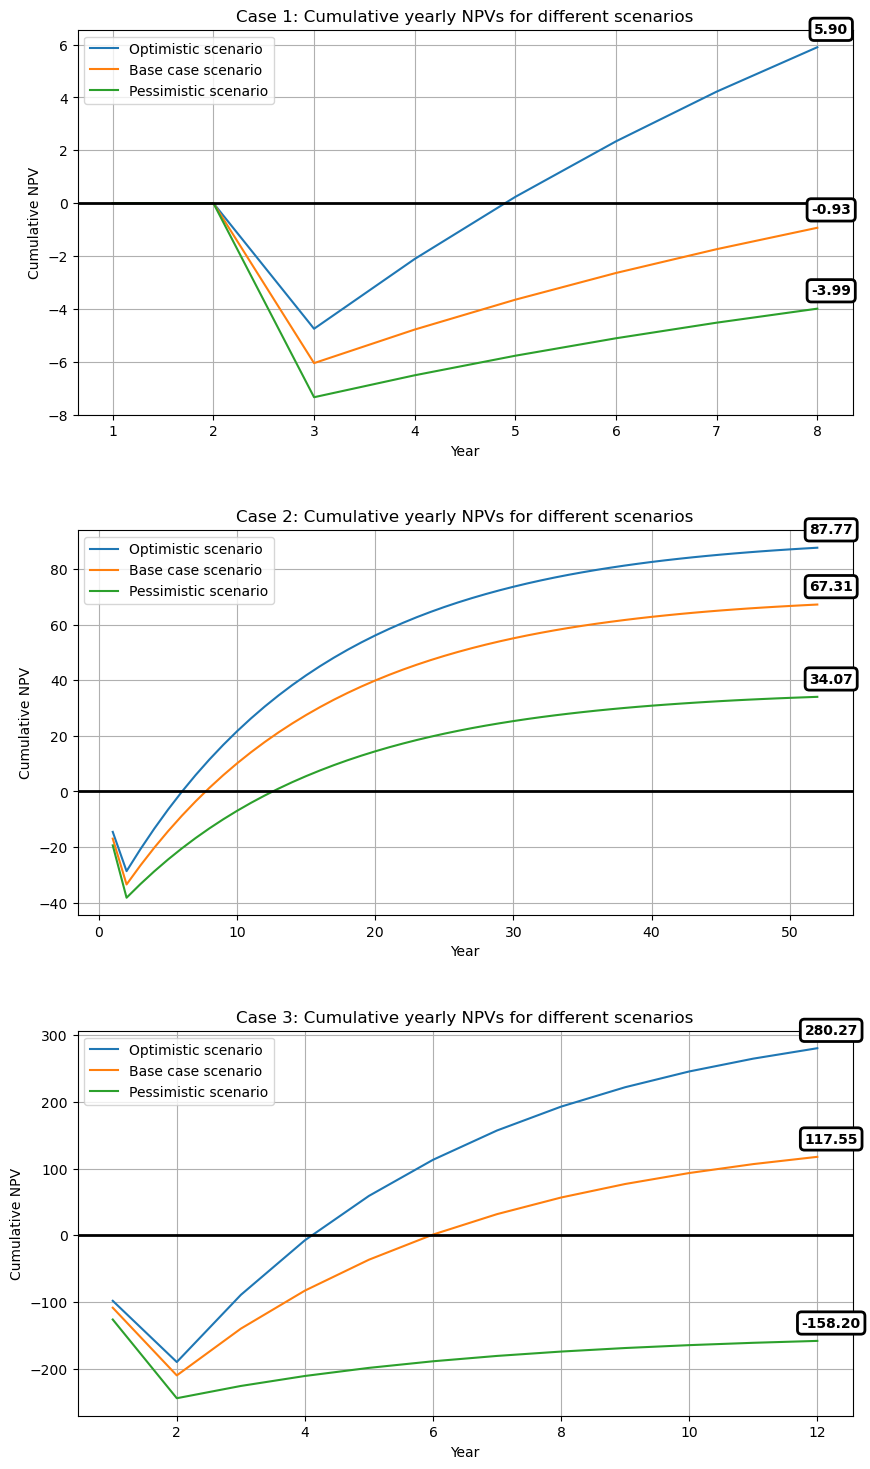

In [109]:
fig, axs = plt.subplots(3, 1, figsize=(10, 18))

for i, ax in enumerate(axs, start=1):
    cumulative_cash_flows_low = np.cumsum(case_data[i]["yearly_cash_flows"]["low"])
    cumulative_cash_flows_mode = np.cumsum(case_data[i]["yearly_cash_flows"]["base"])
    cumulative_cash_flows_high = np.cumsum(case_data[i]["yearly_cash_flows"]["high"])

    years = range(1, len(case_data[i]["yearly_cash_flows"]["low"]) + 1)

    ax.plot(years, cumulative_cash_flows_high, label='Optimistic scenario')
    ax.plot(years, cumulative_cash_flows_mode, label='Base case scenario')
    ax.plot(years, cumulative_cash_flows_low, label='Pessimistic scenario')

    ax.axhline(0, color='black', linewidth=2)

    # Add original boxed annotations for final cumulative values
    bbox_props = dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=2)
    ax.annotate(f'{cumulative_cash_flows_low[-1]:.2f}', (years[-1], cumulative_cash_flows_low[-1]), textcoords="offset points", xytext=(10,10), ha='center', fontsize=10, fontweight='bold', bbox=bbox_props)
    ax.annotate(f'{cumulative_cash_flows_mode[-1]:.2f}', (years[-1], cumulative_cash_flows_mode[-1]), textcoords="offset points", xytext=(10,10), ha='center', fontsize=10, fontweight='bold', bbox=bbox_props)
    ax.annotate(f'{cumulative_cash_flows_high[-1]:.2f}', (years[-1], cumulative_cash_flows_high[-1]), textcoords="offset points", xytext=(10,10), ha='center', fontsize=10, fontweight='bold', bbox=bbox_props)

    ax.set_xlabel('Year')
    ax.set_ylabel('Cumulative NPV')
    ax.set_title(f'Case {i}: Cumulative yearly NPVs for different scenarios')
    ax.legend()
    ax.grid(True)

plt.subplots_adjust(hspace=0.3)
plt.show()

### Preparing for simulation

The cell below must be run before starting the Monte Carlo simulation in order to account for unique parameters of some cases.

In [110]:
# Loops through all cases and calculates discounted values for each investment forming sampling ranges for Monte Carlo simulation
for case_number, case in enumerate(case_data.values(), start=1):
    inputs = case["inputs"]
    case["inputs"]["total_op_revenues"] = calculate_discounted_values(inputs["yearly_op_revenues_range"], inputs["operating_risk_rate"], inputs["start_operating_after_periods"], inputs["periods_in_operation"])
    case["inputs"]["total_op_costs"] = calculate_discounted_values(inputs["yearly_op_cost_range"], inputs["operating_risk_rate"], inputs["start_operating_after_periods"], inputs["periods_in_operation"])
    # For all cases we calculate the discounted launch costs as spread across the years before launch
    case["inputs"]["launch_cost"] = {k: sum((v / inputs["start_operating_after_periods"]) / (1 + inputs["launch_cost_risk_rate"]) ** period for period in range(1, inputs["start_operating_after_periods"] + 1)) for k, v in inputs["total_launch_cost_range"].items()}

# Applies to the third business case. This code adjusts the to-be simulated values to consider only the Finnish government's share of the venture in the JV case
keys = ["total_op_revenues", "total_op_costs", "launch_cost"]
for key in keys:
    case_data[3]["inputs"][key] = {k: v * 0.3 for k, v in case_data[3]["inputs"][key].items()}

### Perform the Monte Carlo simulation

{'start_operating_after_periods': 3, 'periods_in_operation': 5, 'operating_risk_rate': 0.12, 'launch_cost_risk_rate': 0.05, 'yearly_op_revenues_range': {'pess': 2.5, 'base': 3, 'opti': 5}, 'yearly_op_cost_range': {'pess': 1.2, 'base': 1, 'opti': 0.85}, 'total_launch_cost_range': {'pess': 8.5, 'base': 7, 'opti': 5.5}}
